In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
from surprise import Dataset, Reader, SVD, SVDpp, accuracy, KNNBasic
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import train_test_split
from tqdm import tqdm
import logging
import math
from scipy.optimize import curve_fit
import operator
from scipy.spatial.distance import jensenshannon
import json
import pickle as pickle
from itertools import chain, combinations
import sys
import heapq
from functools import partial
from sklearn.model_selection import ParameterSampler

In [3]:
#ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
ratings = pd.read_csv('ml-1m-2/ratings.dat', sep="::", engine="python", names=['userId', 'movieId', 'rating', 'timestamp'])

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   userId     1000209 non-null  int64         
 1   movieId    1000209 non-null  int64         
 2   rating     1000209 non-null  int64         
 3   timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.5 MB


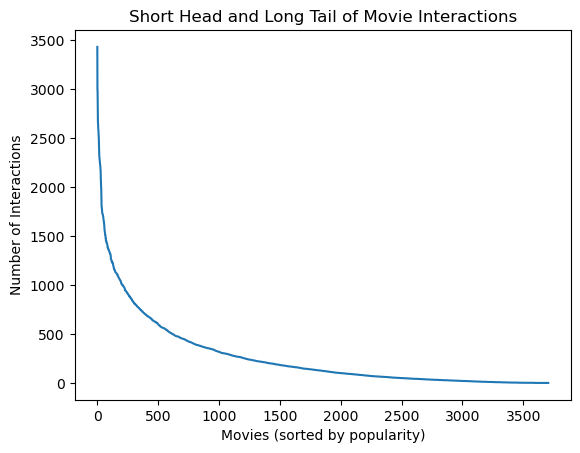

In [5]:
# Count ratings per movie and sort in descending order
movie_interactions = ratings['movieId'].value_counts().sort_values(ascending=False)

plt.plot(movie_interactions.values)
plt.title('Short Head and Long Tail of Movie Interactions')
plt.xlabel('Movies (sorted by popularity)')
plt.ylabel('Number of Interactions')
plt.show()


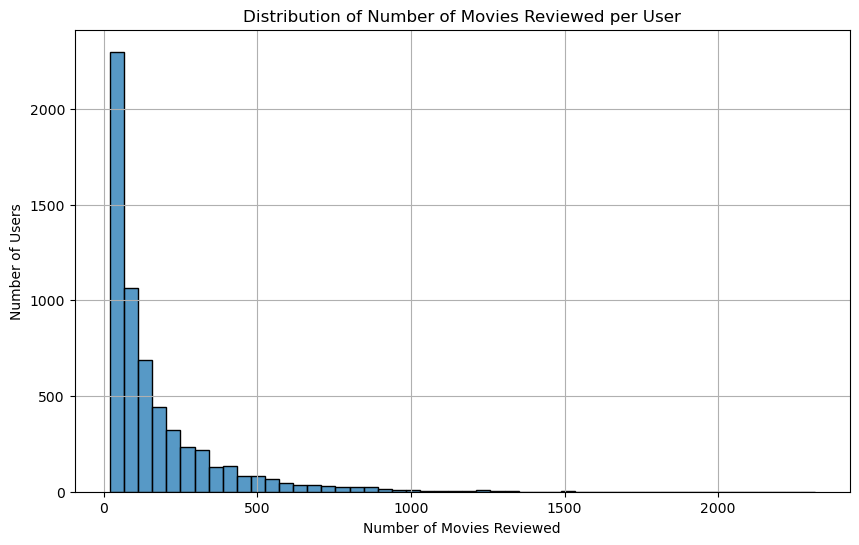

Number of users: 6040


In [6]:
user_review_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, bins=50, kde=False)

plt.title('Distribution of Number of Movies Reviewed per User')
plt.xlabel('Number of Movies Reviewed')
plt.ylabel('Number of Users')
#plt.yscale('log') 
plt.grid(True)
plt.show()
print(f"Number of users: {ratings['userId'].nunique()}")


In [7]:
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity of the dataset: {sparsity:.4f}")

Sparsity of the dataset: 0.9553


## SVD++ Model

In [8]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
        recall_avg = sum(rec for rec in recalls.values()) / len(recalls)

    return precision_avg, recall_avg

In [9]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    #array += 0.0000001
    np.add(array, 0.0000001, out=array, casting="unsafe")
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [10]:
def calculate_gini_of_recommendations(recommendation_counts):
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_counts.values()))

    # Calculate the Gini index
    gini_index = gini(recommendation_array)
    return gini_index

In [11]:
def arp_(users, recs, popularity):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        popularity_sum = 0
        for item in rec:
            p = popularity[int(item)]
            popularity_sum += p
        popularity_sum = popularity_sum/len(rec)
        users_sum += popularity_sum
    res = res * users_sum
    return res


In [12]:
def aplt(users, recs, long_tail):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        num_long_tail = len(set(long_tail).intersection(set(rec)))
        users_sum += num_long_tail/len(rec)
    res = res * users_sum
    return res

In [13]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)

def split_by_month(df, start_date, end_date):
    train_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]
    test_df = df[df['timestamp'] >= end_date]

    # Ensure that the test set contains only users and items from the train set
    test_df = test_df[test_df['userId'].isin(train_df['userId']) & test_df['movieId'].isin(train_df['movieId'])]

    reader = Reader(rating_scale=(1, 5))

    train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

    trainset = train_data.build_full_trainset()

    testset = list(test_df[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))
    

    return trainset, testset, train_df, test_df

In [14]:

# Make month indices 
ratings = ratings.sort_values('timestamp').copy()
ratings['ym'] = ratings['timestamp'].dt.to_period('M')
unique_periods = np.sort(ratings['ym'].unique())
period_to_idx = {p: i+1 for i, p in enumerate(unique_periods)}
ratings['month_idx'] = ratings['ym'].map(period_to_idx)
M = int(ratings['month_idx'].max())

# Random search space ---
param_distributions = {
    'n_factors': [8, 16, 32, 64, 128, 256],
    'n_epochs':  [30, 40, 50, 60, 80, 100],
    'lr_all':    [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 0.1, 1.0],
    'reg_all':   [1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1],
}
n_iter = 40
random_state = 42
rng = np.random.RandomState(random_state)
sampled = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=rng))

# Force-in extremes
extreme_min = {'n_factors': 8,   'n_epochs': 30,  'lr_all': 1e-5, 'reg_all': 1e-5}
extreme_max = {'n_factors': 256, 'n_epochs': 100, 'lr_all': 1.0,  'reg_all': 0.1}
def _contains(lst, d): return any(all(x[k] == d[k] for k in d) for x in lst)
if not _contains(sampled, extreme_min): sampled.insert(0, extreme_min)
if not _contains(sampled, extreme_max): sampled.insert(1, extreme_max)


reader = Reader(rating_scale=(1, 5))
def to_surprise_trainset(df):
    data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
    return data.build_full_trainset()
def to_surprise_testset(df):
    return list(zip(df['userId'].tolist(), df['movieId'].tolist(), df['rating'].tolist()))

# Rolling train (<= t-1), val (== t), test (== t+1) ---
rows = []
best_params_by_month = {}

for t in range(2, M):  # last usable is M-1
    train_df = ratings[ratings['month_idx'] <  t]
    val_df   = ratings[ratings['month_idx'] == t]
    test_df  = ratings[ratings['month_idx'] == t+1]
    if len(train_df)==0 or len(val_df)==0 or len(test_df)==0:
        continue

    trainset     = to_surprise_trainset(train_df)
    val_testset  = to_surprise_testset(val_df)
    test_testset = to_surprise_testset(test_df)

    # Validate: choose params by Precision@10 (tie-break lower RMSE) 
    cand_rows = []
    for params in sampled:
        model = SVD(**params, random_state=random_state)
        model.fit(trainset)
        val_preds = model.test(val_testset)
        val_rmse  = accuracy.rmse(val_preds, verbose=False)


        p_at_10, r_at_10 = precision_recall_at_k(val_preds, k=10, threshold=3.5)

        cand_rows.append({
            'month': t,
            **params,
            'val_precision@10': p_at_10,
            'val_recall@10': r_at_10,
            'val_rmse': val_rmse
        })

    cand_df = (pd.DataFrame(cand_rows)
               .sort_values(['val_precision@10','val_rmse'], ascending=[False, True])
               .reset_index(drop=True))
    best_params = {k: cand_df.loc[0, k] for k in ['n_factors','n_epochs','lr_all','reg_all']}
    best_params_by_month[t] = {
        'n_factors': int(best_params['n_factors']),
        'n_epochs' : int(best_params['n_epochs']),
        'lr_all'   : float(best_params['lr_all']),
        'reg_all'  : float(best_params['reg_all']),
    }

    #Refit on train+val, evaluate on test
    trainval_df = ratings[ratings['month_idx'] <= t]
    trainvalset = to_surprise_trainset(trainval_df)

    final_model = SVD(**best_params_by_month[t], random_state=random_state)
    final_model.fit(trainvalset)
    test_preds = final_model.test(test_testset)
    test_rmse  = accuracy.rmse(test_preds, verbose=False)

    # floats again
    test_p_at_10, test_r_at_10 = precision_recall_at_k(test_preds, k=10, threshold=3.5)

    rows.append({
        'month': t,
        **best_params_by_month[t],
        'val_precision@10': cand_df.loc[0, 'val_precision@10'],
        'val_rmse': cand_df.loc[0, 'val_rmse'],
        'test_precision@10': test_p_at_10,
        'test_recall@10': test_r_at_10,
        'test_rmse': test_rmse
    })

#Save chosen params 
valtest_summary = pd.DataFrame(rows).sort_values('month')
with open('svd_params_by_month_valselect.json','w') as f:
    json.dump(best_params_by_month, f, indent=2)
valtest_summary.to_csv('svd_val_test_summary.csv', index=False)

print("Saved:")
print(" - svd_params_by_month_valselect.json (params chosen by validation Precision@10)")
print(" - svd_val_test_summary.csv (validation & test metrics)")
display(valtest_summary.head())



Saved:
 - svd_params_by_month_valselect.json (params chosen by validation Precision@10)
 - svd_val_test_summary.csv (validation & test metrics)


,month,n_factors,n_epochs,lr_all,reg_all,val_precision@10,val_rmse,test_precision@10,test_recall@10,test_rmse
0,2,256,60,0.010,0.050,0.810647,1.067458,0.800184,0.292388,0.998146
1,3,16,80,0.001,0.001,0.806348,1.011193,0.813458,0.283229,0.993851
2,4,256,80,0.005,0.050,0.819930,0.979570,0.812852,0.257967,0.990638
3,5,256,80,0.005,0.050,0.812852,0.990638,0.794500,0.366428,0.968042
4,6,256,80,0.005,0.050,0.794500,0.968042,0.778594,0.404740,0.951558


In [15]:
def evaluate_over_months(ratings, num_months, best_params_by_month=None):
    results = []
    recommendations = []
    train_test_sets = []
    original_recs = {}
    
    popularity = ratings['movieId'].value_counts(normalize=True).to_dict()
    max_popularity = max(popularity.values())
    popularity = {k: v / max_popularity for k, v in popularity.items()}

    long_tail_items = set(G[2])  

    start_date = ratings['timestamp'].min()

    for month_n in range(1, num_months + 1):
        end_date = start_date + pd.DateOffset(months=1)
        logging.info(f"Processing month {month_n} ({start_date.date()} to {end_date.date()})...")
        
        trainset, testset, train_df, test_df = split_by_month(ratings, start_date, end_date)
        train_test_sets.append((trainset, testset, train_df, test_df))
        
        #Changed: pick per-month params if provided 
        params = {}
        if best_params_by_month is not None:
            params = best_params_by_month.get(month_n, best_params_by_month.get(str(month_n), {}))
        model = SVD(**params, random_state=42)
        # ----------------------------------------------------

        logging.info(f"Starting training for month {month_n}...")
        model.fit(trainset)
        logging.info(f"Training complete for month {month_n}.")
        
        predictions = model.test(testset)

        rmse = accuracy.rmse(predictions, verbose=False)
        precision, recall = precision_recall_at_k(predictions, k=10)

        logging.info(f"month {month_n} RMSE: {rmse:.4f}")

        active_users = train_df['userId'].unique()
        candidate_items = set(train_df['movieId'].unique())
        user_rated_dict = train_df.groupby('userId')['movieId'].apply(set).to_dict()

        recs = {}
        logging.info(f"Generating recommendations for {len(active_users)} active users in month {month_n}...")
        
        for user_id in tqdm(active_users, desc=f"Recommending for month {month_n}"):
            rated_items = user_rated_dict.get(user_id, set())
            user_candidates = candidate_items - rated_items

            top_candidates = heapq.nlargest(100, user_candidates,
                                            key=lambda movie: model.predict(user_id, movie).est)

            user_recommendations = [(movie, model.predict(user_id, movie).est) for movie in top_candidates]
            top_ten = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:10]
            recs[user_id] = [movie for movie, rating in top_ten]

            recommendations.extend([(user_id, movie, rating, month_n) for movie, rating in user_recommendations])

        original_recs[month_n] = recs.copy()
        
        arp_value = arp_(active_users, recs, popularity)
        aplt_value = aplt(active_users, recs, long_tail_items)
        recommendation_count = Counter([movie_id for user_recs in recs.values() for movie_id in user_recs])
        gini_index = calculate_gini_of_recommendations(recommendation_count)

        results.append({
            'month': month_n,
            'rmse': rmse,
            'num_active_users': len(active_users),
            'precision@10': precision,
            'recall@10': recall,
            'gini_index': gini_index,
            'arp': arp_value,
            'aplt': aplt_value,
        })

        start_date = end_date

    recommendations_df = pd.DataFrame(recommendations, columns=['userId', 'movieId', 'rating', 'month'])
    recommendations_df.to_csv("monthly_recommendations.csv", index=False)

    return results, recommendations_df, train_test_sets, original_recs



## Calibrated Popularity

In [16]:
def calib_rec_greedy(recs, alpha, k):
    reranked = []
    users=recs.userId.unique()

    for u in tqdm(users):
        #print("------------------------------------------------------")
        user_recs = recs.loc[recs['userId'] == u]
        user_recs = user_recs.drop_duplicates(subset=['movieId'])
        
        rating_dict = {}
        for index, row in user_recs.iterrows():
            rating_dict[row['movieId']] = row["rating"]

        #og user probabilities
        rated = UG_tolerance_map[u]

        #get all the items recommended for the user in ALS100
        items = user_recs.movieId.unique()

        T = items[:10]
        X = items[10:]

        old_list = items[:10]
        #print("User:", u, "; Original list:", old_list)
        new_list = items[:10]
        for index in range(1, 11):
            #print(index)
            #print("Old list:", old_list)
            delta = 0
            new_list = old_list.copy()
            init_cp = cp(old_list, rated, rating_dict, 0.9)
            #print("Init CP:", init_cp)
            for i in X:
                new_list[-index] = i
                new_cp = cp(new_list, rated, rating_dict, 0.9)
                #print("Item:", i, "\nNew list:", new_list, "\nCP score:", new_cp)
                if new_cp-init_cp>delta:
                    '''print("******************************")
                    print("Found better CP value!")
                    print("List:", new_list)
                    print("CP score:", new_cp)
                    print("******************************")'''
                    old_list = new_list.copy()
                    delta = new_cp-init_cp
            #print("=========================")


        #print("Best list candidate:", better_list)
        #reranked[u] = better_list
        for item in old_list:
            score = user_recs.loc[user_recs['movieId'] == item, 'rating'].item()
            #print("rating:", score)
            d = {'userId':u, 'movieId':item, 'rating':score}
            #print(d)
            reranked.append(d)

    return reranked

In [17]:
#=====================================================================
#METHODS
#method to categorize users into mainstream, niche and in-between
#takes original rating dataset as a parameter, returns a dict with user IDs and popularity group they belong to
def user_tol_cat(df):
    UG_map={}
    for u in users:
        UG1=[]
        UG2=[]
        UG3=[]
        rated=df[df.userId==u]['movieId']
        for i in rated:
            if i in G[0]:
                UG1.append(i)
            elif i in G[1]:
                UG2.append(i)
            else:
                UG3.append(i)
        UG_map[u]=[len(UG1),len(UG2),len(UG3)]

    UG_tolerance_map={}
    for u in users:
        u_g=UG_map[u]
        s=sum(u_g)
        UG_tolerance_map[u]=[float(x)/s for x in u_g]
    return UG_tolerance_map



# figure out what item index in an ordered list would be a cut-off point for a certain percentage
def find_short_head_split_point(sorted_list,percentage):
    s=0.0
    eightyPercent=float(sum(sorted_list))*percentage
    for i in range(len(sorted_list)):
        s+=sorted_list[i]
        if s>=eightyPercent:
            return i

# this method does the calculation magic - checks the relevance of the newly re-ranked list, as well as divergence between recommendation vector and user vector
def cp(recom, rated, rating_dict, alpha):

    UG_map=[len(set(G[0]).intersection(set(recom))),len(set(G[1]).intersection(set(recom))),len(set(G[2]).intersection(set(recom)))]
    UG_map = [float(x)/10 for x in UG_map]

    relevance_sum = 0
    for i in recom:
        rating = rating_dict[i]
        relevance_sum += rating

    left = (1-alpha)*relevance_sum
    j = jensenshannon(rated,UG_map)
    right = alpha*j
    res = left-right
    return res

def cali(recs100, alpha, k, month):
    print(f"Adding 'month' column for month {month}...")
    recs100['month'] = month  
    print("Checking recs100 before reranking:")
    print(recs100.head())  

    print("####### Starting the reranking...")
    reranked = calib_rec_greedy(recs100, alpha, k)
    
    # Check if reranked is a DataFrame, if not, convert it to one
    if not isinstance(reranked, pd.DataFrame):
        reranked = pd.DataFrame(reranked, columns=['userId', 'movieId', 'rating'])

    print("Checking reranked DataFrame:")
    print(reranked.head())  # Check if 'month' column is still there
    
    reranked['month'] = month  # Add the 'month' column manually here
    print("Checking reranked DataFrame after adding 'month':")
    print(reranked.head())

    reranked.to_csv(res_path, index=False)
    return reranked


In [18]:
alpha = 0.9
k = 10

# list of user IDs for utility
users = []
res_path = "svd_re-ranking"

In [19]:
# save a list of user IDs in a utility variable we have above for future use, it will come handy
users=ratings.userId.unique()

# calculate item popularities in the original rating dataset
item_pops=ratings.groupby('movieId').size()/len(ratings.userId.unique())
#item_pops.head()
item_pops_total=ratings.groupby('movieId').size()

sorted_item_pops_map = sorted(item_pops_total.items(),reverse=True,key=operator.itemgetter(1))
sorted_items=[x[0] for x in sorted_item_pops_map]
sorted_ratio=[x[1] for x in sorted_item_pops_map]

# find out where are the thresholds between head and mid items, mid and tail items
short_head_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.2)
mid_tail_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.8)

# put items into separate popularity groups
indexes=[short_head_point,mid_tail_point,len(item_pops)]
global G
G =[]
s=0
for i in range(len(indexes)):
    G.append([x[0] for x in sorted_item_pops_map[s:int(indexes[i])]])
    s=int(indexes[i])
G_names=[]
for i in range(len(G)):
    G_names.append("G%s"%(i+1))

# just double checking the lists of items with different popularites
print("Lengths of G lists:")
for l in G:
    print(len(l))

# now we can split the users into different groups based on their popularity preference too
# we will need the original rating dataset for this too
print("Calculating original user tolerance map...")
global UG_tolerance_map
UG_tolerance_map=user_tol_cat(ratings)

Lengths of G lists:
112
1069
2525
Calculating original user tolerance map...


In [20]:
# Convert to a list of tolerance distributions
tolerances = list(UG_tolerance_map.values())

# Convert to a NumPy array for easier analysis
tolerance_array = np.array(tolerances)

# Calculate mean tolerance for each category (e.g., Head, Mid, Tail)
mean_tolerance = tolerance_array.mean(axis=0)
print(f"Mean tolerance: {mean_tolerance}")

# Check variance or standard deviation
std_tolerance = tolerance_array.std(axis=0)
print(f"Standard deviation: {std_tolerance}")

Mean tolerance: [0.26824432 0.57199277 0.15976291]
Standard deviation: [0.12167725 0.09051926 0.10418744]


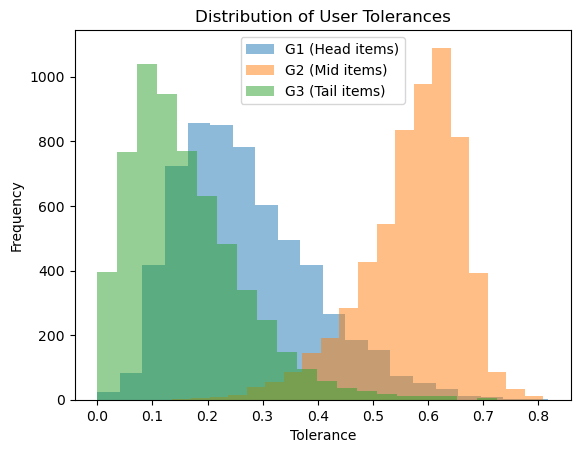

In [21]:
# Create separate lists for each category (e.g., G1, G2, G3)
g1, g2, g3 = tolerance_array.T  # Transpose to split into groups

# Plot histograms for each category
plt.hist(g1, bins=20, alpha=0.5, label="G1 (Head items)")
plt.hist(g2, bins=20, alpha=0.5, label="G2 (Mid items)")
plt.hist(g3, bins=20, alpha=0.5, label="G3 (Tail items)")

plt.title("Distribution of User Tolerances")
plt.xlabel("Tolerance")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("user_tolerances")
plt.show()

## Running the model

In [23]:
# ================= MAIN =================

#Load per-month optimal params chosen earlier via the train→val→test search
try:
    with open('svd_params_by_month_valselect.json') as f:
        best_params_by_month = {int(k): v for k, v in json.load(f).items()}
    logging.info("Loaded per-month SVD params from svd_params_by_month_valselect.json")
except FileNotFoundError:
    best_params_by_month = None
    logging.warning("svd_params_by_month_valselect.json not found — using Surprise defaults.")

#Run monthly evaluation with those params
num_months = 32
monthly_results, recommendations_df, train_test_sets, original_recs = evaluate_over_months(
    ratings, 
    num_months, 
    best_params_by_month=best_params_by_month  
)

#Save the monthly results table
pd.DataFrame(monthly_results).to_csv("monthly_results_with_params.csv", index=False)

# CP re-ranking 
all_reranked_recommendations = []
for month in range(1, num_months + 1):
    print(f"Processing month {month}...")
    monthly_recommendations = recommendations_df[recommendations_df['month'] == month]

    print(f"Checking monthly recommendations for month {month}:")
    print(monthly_recommendations.head())

    logging.info(f"Applying CP re-ranking for month {month}...")
    reranked_recommendations = cali(monthly_recommendations, alpha, k, month)
    all_reranked_recommendations.append(reranked_recommendations)

#Combine & save CP outputs
reranked_df = pd.concat(all_reranked_recommendations, ignore_index=True)
print("Checking final reranked_df:")
print(reranked_df.head())

reranked_df.to_csv("monthly_reranked_recommendations.csv", index=False)

# (optional) show metrics summary
print(pd.DataFrame(monthly_results))


2025-09-30 23:38:06,815 - Loaded per-month SVD params from svd_params_by_month_valselect.json
2025-09-30 23:38:06,828 - Processing month 1 (2000-04-25 to 2000-05-25)...
2025-09-30 23:38:06,902 - Starting training for month 1...
2025-09-30 23:38:07,158 - Training complete for month 1.
2025-09-30 23:38:07,188 - month 1 RMSE: 0.9964
2025-09-30 23:38:07,197 - Generating recommendations for 466 active users in month 1...
Recommending for month 1: 100%|██████████████| 466/466 [00:02<00:00, 219.66it/s]
2025-09-30 23:38:09,327 - Processing month 2 (2000-05-25 to 2000-06-25)...
2025-09-30 23:38:09,393 - Starting training for month 2...
2025-09-30 23:38:10,864 - Training complete for month 2.
2025-09-30 23:38:10,897 - month 2 RMSE: 0.9231
2025-09-30 23:38:10,907 - Generating recommendations for 515 active users in month 2...
Recommending for month 2: 100%|██████████████| 515/515 [00:02<00:00, 203.16it/s]
2025-09-30 23:38:13,450 - Processing month 3 (2000-06-25 to 2000-07-25)...
2025-09-30 23:38:

Recommending for month 20: 100%|█████████████| 174/174 [00:00<00:00, 407.99it/s]
2025-09-30 23:39:21,706 - Processing month 21 (2001-12-25 to 2002-01-25)...
2025-09-30 23:39:21,716 - Starting training for month 21...
2025-09-30 23:39:21,733 - Training complete for month 21.
2025-09-30 23:39:21,750 - month 21 RMSE: 0.9874
2025-09-30 23:39:21,753 - Generating recommendations for 228 active users in month 21...
Recommending for month 21: 100%|█████████████| 228/228 [00:00<00:00, 314.50it/s]
2025-09-30 23:39:22,482 - Processing month 22 (2002-01-25 to 2002-02-25)...
2025-09-30 23:39:22,491 - Starting training for month 22...
2025-09-30 23:39:22,498 - Training complete for month 22.
2025-09-30 23:39:22,513 - month 22 RMSE: 0.9979
2025-09-30 23:39:22,516 - Generating recommendations for 196 active users in month 22...
Recommending for month 22: 100%|█████████████| 196/196 [00:00<00:00, 342.07it/s]
2025-09-30 23:39:23,092 - Processing month 23 (2002-02-25 to 2002-03-25)...
2025-09-30 23:39:23

Processing month 1...
Checking monthly recommendations for month 1:
   userId  movieId    rating  month
0    6040     1267  4.599123      1
1    6040     1304  4.579606      1
2    6040      969  4.480147      1
3    6040     1950  4.470288      1
4    6040     1281  4.432052      1
Adding 'month' column for month 1...
Checking recs100 before reranking:
   userId  movieId    rating  month
0    6040     1267  4.599123      1
1    6040     1304  4.579606      1
2    6040      969  4.480147      1
3    6040     1950  4.470288      1
4    6040     1281  4.432052      1
####### Starting the reranking...


 75%|██████████████████████████████▌          | 348/466 [00:15<00:05, 22.58it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 466/466 [00:21<00:00, 22.13it/s]
2025-09-30 23:39:51,783 - Applying CP re-ranking for month 2...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    6040     1267  4.599123
1    6040     1304  4.579606
2    6040      969  4.480147
3    6040     1950  4.470288
4    6040     1281  4.432052
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    6040     1267  4.599123      1
1    6040     1304  4.579606      1
2    6040      969  4.480147      1
3    6040     1950  4.470288      1
4    6040     1281  4.432052      1
Processing month 2...
Checking monthly recommendations for month 2:
       userId  movieId  rating  month
46600    5574      745     5.0      2
46601    5574      905     5.0      2
46602    5574      913     5.0      2
46603    5574     1223     5.0      2
46604    5574     1233     5.0      2
Adding 'month' column for month 2...
Checking recs100 before reranking:
       userId  movieId  rating  month
46600    5574      745     5.0      2
46601    5574      905     5.0      2
46602    5574      913     5.0      2
46603    55

100%|█████████████████████████████████████████| 515/515 [00:23<00:00, 22.26it/s]
2025-09-30 23:40:14,947 - Applying CP re-ranking for month 3...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId  rating
0    5574      745     5.0
1    5574      905     5.0
2    5574      913     5.0
3    5574     1223     5.0
4    5574     1233     5.0
Checking reranked DataFrame after adding 'month':
   userId  movieId  rating  month
0    5574      745     5.0      2
1    5574      905     5.0      2
2    5574      913     5.0      2
3    5574     1223     5.0      2
4    5574     1233     5.0      2
Processing month 3...
Checking monthly recommendations for month 3:
       userId  movieId    rating  month
98100    5256      745  5.000000      3
98101    5256     1148  5.000000      3
98102    5256      720  4.981010      3
98103    5256      750  4.979095      3
98104    5256     1207  4.959443      3
Adding 'month' column for month 3...
Checking recs100 before reranking:
       userId  movieId    rating  month
98100    5256      745  5.000000      3
98101    5256     1148  5.000000      3
98102    5256      720  4.981010      3
98103    5256  

 52%|█████████████████████▏                   | 378/733 [00:16<00:15, 22.43it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 733/733 [00:32<00:00, 22.28it/s]
2025-09-30 23:40:47,869 - Applying CP re-ranking for month 4...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5256      745  5.000000
1    5256     1148  5.000000
2    5256      720  4.981010
3    5256      750  4.979095
4    5256     1207  4.959443
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5256      745  5.000000      3
1    5256     1148  5.000000      3
2    5256      720  4.981010      3
3    5256      750  4.979095      3
4    5256     1207  4.959443      3
Processing month 4...
Checking monthly recommendations for month 4:
        userId  movieId    rating  month
171400    4682     1212  4.844743      4
171401    4682     1284  4.704789      4
171402    4682      306  4.686254      4
171403    4682     2858  4.681094      4
171404    4682     1147  4.622132      4
Adding 'month' column for month 4...
Checking recs100 before reranking:
        userId  movieId    rating  month
171400    4682     1212  4.844743      4
171401    4682     1284  4.704789      4
171402    4682      30

 26%|██████████▌                             | 339/1284 [00:15<00:41, 22.92it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|███████████████████████████████████████| 1284/1284 [00:57<00:00, 22.35it/s]
2025-09-30 23:41:45,363 - Applying CP re-ranking for month 5...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    4682     1212  4.844743
1    4682     1284  4.704789
2    4682      306  4.686254
3    4682     2858  4.681094
4    4682     1147  4.622132
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    4682     1212  4.844743      4
1    4682     1284  4.704789      4
2    4682      306  4.686254      4
3    4682     2858  4.681094      4
4    4682     1147  4.622132      4
Processing month 5...
Checking monthly recommendations for month 5:
        userId  movieId    rating  month
299800    3450     1963  4.729271      5
299801    3450      318  4.681772      5
299802    3450     1131  4.646139      5
299803    3450      527  4.631239      5
299804    3450     1147  4.618609      5
Adding 'month' column for month 5...
Checking recs100 before reranking:
        userId  movieId    rating  month
299800    3450     1963  4.729271      5
299801    3450      318  4.681772      5
299802    3450     113

100%|█████████████████████████████████████████| 650/650 [00:29<00:00, 22.22it/s]
2025-09-30 23:42:14,644 - Applying CP re-ranking for month 6...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3450     1963  4.729271
1    3450      318  4.681772
2    3450      953  4.515611
3    3450      527  4.631239
4    3450     1147  4.618609
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3450     1963  4.729271      5
1    3450      318  4.681772      5
2    3450      953  4.515611      5
3    3450      527  4.631239      5
4    3450     1147  4.618609      5
Processing month 6...
Checking monthly recommendations for month 6:
        userId  movieId    rating  month
364800    5520      110  4.797065      6
364801    5520     2329  4.778898      6
364802    5520      318  4.757717      6
364803    5520     3578  4.627193      6
364804    5520     1198  4.612540      6
Adding 'month' column for month 6...
Checking recs100 before reranking:
        userId  movieId    rating  month
364800    5520      110  4.797065      6
364801    5520     2329  4.778898      6
364802    5520      31

100%|█████████████████████████████████████████| 482/482 [00:21<00:00, 22.25it/s]
2025-09-30 23:42:36,329 - Applying CP re-ranking for month 7...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5520      110  4.797065
1    5520     2329  4.778898
2    5520      318  4.757717
3    5520     3578  4.627193
4    5520     1172  4.444820
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5520      110  4.797065      6
1    5520     2329  4.778898      6
2    5520      318  4.757717      6
3    5520     3578  4.627193      6
4    5520     1172  4.444820      6
Processing month 7...
Checking monthly recommendations for month 7:
        userId  movieId    rating  month
413000    2847     3949  4.275761      7
413001    2847      858  4.217967      7
413002    2847     1809  4.128982      7
413003    2847     2019  4.099557      7
413004    2847     1221  4.095500      7
Adding 'month' column for month 7...
Checking recs100 before reranking:
        userId  movieId    rating  month
413000    2847     3949  4.275761      7
413001    2847      858  4.217967      7
413002    2847     180

 27%|██████████▉                             | 585/2141 [00:25<01:09, 22.53it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|███████████████████████████████████████| 2141/2141 [01:34<00:00, 22.62it/s]
2025-09-30 23:44:11,068 - Applying CP re-ranking for month 8...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2847     3949  4.275761
1    2847      858  4.217967
2    2847     1809  4.128982
3    2847     2019  4.099557
4    2847     1221  4.095500
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2847     3949  4.275761      7
1    2847      858  4.217967      7
2    2847     1809  4.128982      7
3    2847     2019  4.099557      7
4    2847     1221  4.095500      7
Processing month 8...
Checking monthly recommendations for month 8:
        userId  movieId    rating  month
627100     929     2571  4.649144      8
627101     929     2028  4.633080      8
627102     929     1148  4.616683      8
627103     929      318  4.609642      8
627104     929      745  4.526720      8
Adding 'month' column for month 8...
Checking recs100 before reranking:
        userId  movieId    rating  month
627100     929     2571  4.649144      8
627101     929     2028  4.633080      8
627102     929     114

 53%|█████████████████████                   | 756/1436 [00:33<00:29, 22.90it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|███████████████████████████████████████| 1436/1436 [01:04<00:00, 22.36it/s]
2025-09-30 23:45:15,349 - Applying CP re-ranking for month 9...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     929     2571  4.649144
1     929     2028  4.633080
2     929     1148  4.616683
3     929     1262  4.413669
4     929      745  4.526720
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     929     2571  4.649144      8
1     929     2028  4.633080      8
2     929     1148  4.616683      8
3     929     1262  4.413669      8
4     929      745  4.526720      8
Processing month 9...
Checking monthly recommendations for month 9:
        userId  movieId    rating  month
770700      81      527  5.000000      9
770701      81     2762  5.000000      9
770702      81     3147  4.955104      9
770703      81      750  4.954225      9
770704      81      912  4.942716      9
Adding 'month' column for month 9...
Checking recs100 before reranking:
        userId  movieId    rating  month
770700      81      527  5.000000      9
770701      81     2762  5.000000      9
770702      81     314

100%|█████████████████████████████████████████| 633/633 [00:28<00:00, 22.13it/s]
2025-09-30 23:45:43,984 - Applying CP re-ranking for month 10...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      81      527  5.000000
1      81     2762  5.000000
2      81     3147  4.955104
3      81      345  4.763485
4      81     1949  4.641414
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      81      527  5.000000      9
1      81     2762  5.000000      9
2      81     3147  4.955104      9
3      81      345  4.763485      9
4      81     1949  4.641414      9
Processing month 10...
Checking monthly recommendations for month 10:
        userId  movieId    rating  month
834000    5874     2019  4.386861     10
834001    5874      608  4.227863     10
834002    5874      318  4.220466     10
834003    5874      858  4.213286     10
834004    5874     3897  4.202995     10
Adding 'month' column for month 10...
Checking recs100 before reranking:
        userId  movieId    rating  month
834000    5874     2019  4.386861     10
834001    5874      608  4.227863     10
834002    5874     

100%|█████████████████████████████████████████| 429/429 [00:19<00:00, 22.23it/s]
2025-09-30 23:46:03,299 - Applying CP re-ranking for month 11...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5874     2019  4.386861
1    5874      608  4.227863
2    5874      318  4.220466
3    5874     1797  4.019008
4    5874     3897  4.202995
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5874     2019  4.386861     10
1    5874      608  4.227863     10
2    5874      318  4.220466     10
3    5874     1797  4.019008     10
4    5874     3897  4.202995     10
Processing month 11...
Checking monthly recommendations for month 11:
        userId  movieId    rating  month
876900    4039     1148  4.888500     11
876901    4039      745  4.841781     11
876902    4039     1211  4.830822     11
876903    4039      904  4.771267     11
876904    4039     3730  4.745037     11
Adding 'month' column for month 11...
Checking recs100 before reranking:
        userId  movieId    rating  month
876900    4039     1148  4.888500     11
876901    4039      745  4.841781     11
876902    4039     

100%|█████████████████████████████████████████| 315/315 [00:14<00:00, 22.15it/s]
2025-09-30 23:46:17,536 - Applying CP re-ranking for month 12...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    4039     1148  4.888500
1    4039      745  4.841781
2    4039      527  4.614874
3    4039      904  4.771267
4    4039     3730  4.745037
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    4039     1148  4.888500     11
1    4039      745  4.841781     11
2    4039      527  4.614874     11
3    4039      904  4.771267     11
4    4039     3730  4.745037     11
Processing month 12...
Checking monthly recommendations for month 12:
        userId  movieId    rating  month
908400    2106     3471  3.247465     12
908401    2106     1203  3.114055     12
908402    2106     2501  2.975067     12
908403    2106      448  2.967606     12
908404    2106     2997  2.959992     12
Adding 'month' column for month 12...
Checking recs100 before reranking:
        userId  movieId    rating  month
908400    2106     3471  3.247465     12
908401    2106     1203  3.114055     12
908402    2106     

100%|█████████████████████████████████████████| 307/307 [00:13<00:00, 22.26it/s]
2025-09-30 23:46:31,343 - Applying CP re-ranking for month 13...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2106     3471  3.247465
1    2106     1203  3.114055
2    2106     2501  2.975067
3    2106      448  2.967606
4    2106      154  2.784549
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2106     3471  3.247465     12
1    2106     1203  3.114055     12
2    2106     2501  2.975067     12
3    2106      448  2.967606     12
4    2106      154  2.784549     12
Processing month 13...
Checking monthly recommendations for month 13:
        userId  movieId    rating  month
939100    5319     3897  4.059007     13
939101    5319      318  3.662677     13
939102    5319     3916  3.658936     13
939103    5319     2762  3.650860     13
939104    5319      903  3.646731     13
Adding 'month' column for month 13...
Checking recs100 before reranking:
        userId  movieId    rating  month
939100    5319     3897  4.059007     13
939101    5319      318  3.662677     13
939102    5319     

100%|█████████████████████████████████████████| 254/254 [00:11<00:00, 22.33it/s]
2025-09-30 23:46:42,734 - Applying CP re-ranking for month 14...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5319     3897  4.059007
1    5319      318  3.662677
2    5319     3916  3.658936
3    5319     2762  3.650860
4    5319      903  3.646731
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5319     3897  4.059007     13
1    5319      318  3.662677     13
2    5319     3916  3.658936     13
3    5319     2762  3.650860     13
4    5319      903  3.646731     13
Processing month 14...
Checking monthly recommendations for month 14:
        userId  movieId  rating  month
964500     293      260     5.0     14
964501     293      593     5.0     14
964502     293      913     5.0     14
964503     293     1196     5.0     14
964504     293     1225     5.0     14
Adding 'month' column for month 14...
Checking recs100 before reranking:
        userId  movieId  rating  month
964500     293      260     5.0     14
964501     293      593     5.0     14
964502     293      913     5.0     1

100%|█████████████████████████████████████████| 294/294 [00:13<00:00, 22.16it/s]
2025-09-30 23:46:56,015 - Applying CP re-ranking for month 15...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     293      260  5.000000
1     293     2607  5.000000
2     293      913  5.000000
3     293     1132  4.836255
4     293     1199  4.985288
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     293      260  5.000000     14
1     293     2607  5.000000     14
2     293      913  5.000000     14
3     293     1132  4.836255     14
4     293     1199  4.985288     14
Processing month 15...
Checking monthly recommendations for month 15:
        userId  movieId    rating  month
993900    1181     1284  4.019456     15
993901    1181     3386  3.966526     15
993902    1181      590  3.962257     15
993903    1181      319  3.906660     15
993904    1181      260  3.903443     15
Adding 'month' column for month 15...
Checking recs100 before reranking:
        userId  movieId    rating  month
993900    1181     1284  4.019456     15
993901    1181     3386  3.966526     15
993902    1181     

100%|█████████████████████████████████████████| 288/288 [00:12<00:00, 22.27it/s]
2025-09-30 23:47:08,964 - Applying CP re-ranking for month 16...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    1181     1284  4.019456
1    1181     3386  3.966526
2    1181      590  3.962257
3    1181      319  3.906660
4    1181     3245  3.705991
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    1181     1284  4.019456     15
1    1181     3386  3.966526     15
2    1181      590  3.962257     15
3    1181      319  3.906660     15
4    1181     3245  3.705991     15
Processing month 16...
Checking monthly recommendations for month 16:
         userId  movieId    rating  month
1022700    3158      858  5.000000     16
1022701    3158     1097  4.969554     16
1022702    3158     1221  4.963917     16
1022703    3158     1148  4.962896     16
1022704    3158     1923  4.958699     16
Adding 'month' column for month 16...
Checking recs100 before reranking:
         userId  movieId    rating  month
1022700    3158      858  5.000000     16
1022701    3158     1097  4.969554     16
1022702   

100%|█████████████████████████████████████████| 259/259 [00:11<00:00, 22.26it/s]
2025-09-30 23:47:20,612 - Applying CP re-ranking for month 17...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3158      858  5.000000
1    3158     1097  4.969554
2    3158     2022  4.812635
3    3158     1148  4.962896
4    3158     1212  4.803233
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3158      858  5.000000     16
1    3158     1097  4.969554     16
2    3158     2022  4.812635     16
3    3158     1148  4.962896     16
4    3158     1212  4.803233     16
Processing month 17...
Checking monthly recommendations for month 17:
         userId  movieId    rating  month
1048600    1088     2959  4.790806     17
1048601    1088     1204  4.784817     17
1048602    1088      593  4.781428     17
1048603    1088     2858  4.746590     17
1048604    1088     2692  4.730123     17
Adding 'month' column for month 17...
Checking recs100 before reranking:
         userId  movieId    rating  month
1048600    1088     2959  4.790806     17
1048601    1088     1204  4.784817     17
1048602   

100%|█████████████████████████████████████████| 204/204 [00:09<00:00, 22.62it/s]
2025-09-30 23:47:29,641 - Applying CP re-ranking for month 18...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    1088     2959  4.790806
1    1088     1204  4.784817
2    1088     2384  4.633228
3    1088     3097  4.476534
4    1088     2692  4.730123
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    1088     2959  4.790806     17
1    1088     1204  4.784817     17
2    1088     2384  4.633228     17
3    1088     3097  4.476534     17
4    1088     2692  4.730123     17
Processing month 18...
Checking monthly recommendations for month 18:
         userId  movieId    rating  month
1069000     355     1358  4.456880     18
1069001     355     1207  4.382158     18
1069002     355     2529  4.309094     18
1069003     355     2761  4.274516     18
1069004     355     1240  4.237746     18
Adding 'month' column for month 18...
Checking recs100 before reranking:
         userId  movieId    rating  month
1069000     355     1358  4.456880     18
1069001     355     1207  4.382158     18
1069002   

100%|█████████████████████████████████████████| 175/175 [00:07<00:00, 22.35it/s]
2025-09-30 23:47:37,482 - Applying CP re-ranking for month 19...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     355     1358  4.456880
1     355     1207  4.382158
2     355     2529  4.309094
3     355     2761  4.274516
4     355     1240  4.237746
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     355     1358  4.456880     18
1     355     1207  4.382158     18
2     355     2529  4.309094     18
3     355     2761  4.274516     18
4     355     1240  4.237746     18
Processing month 19...
Checking monthly recommendations for month 19:
         userId  movieId    rating  month
1086500    5493       50  4.886634     19
1086501    5493      527  4.535900     19
1086502    5493     3006  4.479957     19
1086503    5493     1219  4.410914     19
1086504    5493      265  4.408819     19
Adding 'month' column for month 19...
Checking recs100 before reranking:
         userId  movieId    rating  month
1086500    5493       50  4.886634     19
1086501    5493      527  4.535900     19
1086502   

100%|█████████████████████████████████████████| 190/190 [00:08<00:00, 22.75it/s]
2025-09-30 23:47:45,846 - Applying CP re-ranking for month 20...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5493       50  4.886634
1    5493      527  4.535900
2    5493     3006  4.479957
3    5493     1219  4.410914
4    5493      265  4.408819
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5493       50  4.886634     19
1    5493      527  4.535900     19
2    5493     3006  4.479957     19
3    5493     1219  4.410914     19
4    5493      265  4.408819     19
Processing month 20...
Checking monthly recommendations for month 20:
         userId  movieId    rating  month
1105500     349     3897  4.340420     20
1105501     349      903  4.301540     20
1105502     349     3418  4.288586     20
1105503     349     2313  4.268337     20
1105504     349     2502  4.244213     20
Adding 'month' column for month 20...
Checking recs100 before reranking:
         userId  movieId    rating  month
1105500     349     3897  4.340420     20
1105501     349      903  4.301540     20
1105502   

100%|█████████████████████████████████████████| 174/174 [00:07<00:00, 22.48it/s]
2025-09-30 23:47:53,599 - Applying CP re-ranking for month 21...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     349     3897  4.340420
1     349      903  4.301540
2     349     3418  4.288586
3     349     2313  4.268337
4     349     2502  4.244213
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     349     3897  4.340420     20
1     349      903  4.301540     20
2     349     3418  4.288586     20
3     349     2313  4.268337     20
4     349     2502  4.244213     20
Processing month 21...
Checking monthly recommendations for month 21:
         userId  movieId    rating  month
1122900    5424     1251  4.592518     21
1122901    5424      318  4.590567     21
1122902    5424     1221  4.552912     21
1122903    5424     1584  4.531577     21
1122904    5424     1265  4.488643     21
Adding 'month' column for month 21...
Checking recs100 before reranking:
         userId  movieId    rating  month
1122900    5424     1251  4.592518     21
1122901    5424      318  4.590567     21
1122902   

100%|█████████████████████████████████████████| 228/228 [00:10<00:00, 22.30it/s]
2025-09-30 23:48:03,836 - Applying CP re-ranking for month 22...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5424      111  4.430847
1    5424      318  4.590567
2    5424     1221  4.552912
3    5424     1584  4.531577
4    5424     1265  4.488643
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5424      111  4.430847     21
1    5424      318  4.590567     21
2    5424     1221  4.552912     21
3    5424     1584  4.531577     21
4    5424     1265  4.488643     21
Processing month 22...
Checking monthly recommendations for month 22:
         userId  movieId    rating  month
1145700    2022      858  4.666056     22
1145701    2022     2692  4.567548     22
1145702    2022     3471  4.525007     22
1145703    2022      527  4.485583     22
1145704    2022     1292  4.478632     22
Adding 'month' column for month 22...
Checking recs100 before reranking:
         userId  movieId    rating  month
1145700    2022      858  4.666056     22
1145701    2022     2692  4.567548     22
1145702   

100%|█████████████████████████████████████████| 196/196 [00:08<00:00, 22.47it/s]
2025-09-30 23:48:12,571 - Applying CP re-ranking for month 23...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2022      858  4.666056
1    2022     2692  4.567548
2    2022     3471  4.525007
3    2022      527  4.485583
4    2022     1292  4.478632
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2022      858  4.666056     22
1    2022     2692  4.567548     22
2    2022     3471  4.525007     22
3    2022      527  4.485583     22
4    2022     1292  4.478632     22
Processing month 23...
Checking monthly recommendations for month 23:
         userId  movieId    rating  month
1165300     271     3783  4.916002     23
1165301     271     1827  4.770623     23
1165302     271      969  4.765578     23
1165303     271      337  4.753837     23
1165304     271     1244  4.743790     23
Adding 'month' column for month 23...
Checking recs100 before reranking:
         userId  movieId    rating  month
1165300     271     3783  4.916002     23
1165301     271     1827  4.770623     23
1165302   

100%|█████████████████████████████████████████| 160/160 [00:07<00:00, 22.59it/s]
2025-09-30 23:48:19,665 - Applying CP re-ranking for month 24...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     271     3783  4.916002
1     271     3104  4.667418
2     271      969  4.765578
3     271      337  4.753837
4     271     1244  4.743790
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     271     3783  4.916002     23
1     271     3104  4.667418     23
2     271      969  4.765578     23
3     271      337  4.753837     23
4     271     1244  4.743790     23
Processing month 24...
Checking monthly recommendations for month 24:
         userId  movieId    rating  month
1181300    4356     3598  4.776779     24
1181301    4356     2732  4.645876     24
1181302    4356     1204  4.580659     24
1181303    4356     3327  4.521071     24
1181304    4356     2120  4.476743     24
Adding 'month' column for month 24...
Checking recs100 before reranking:
         userId  movieId    rating  month
1181300    4356     3598  4.776779     24
1181301    4356     2732  4.645876     24
1181302   

100%|█████████████████████████████████████████| 146/146 [00:06<00:00, 22.48it/s]
2025-09-30 23:48:26,170 - Applying CP re-ranking for month 25...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    4356     3598  4.776779
1    4356     3481  4.415164
2    4356     1204  4.580659
3    4356     3108  4.363497
4    4356     1207  4.421722
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    4356     3598  4.776779     24
1    4356     3481  4.415164     24
2    4356     1204  4.580659     24
3    4356     3108  4.363497     24
4    4356     1207  4.421722     24
Processing month 25...
Checking monthly recommendations for month 25:
         userId  movieId    rating  month
1195900    1980       29  4.641050     25
1195901    1980     1207  4.546127     25
1195902    1980     3330  4.534180     25
1195903    1980     2565  4.507994     25
1195904    1980     2395  4.502550     25
Adding 'month' column for month 25...
Checking recs100 before reranking:
         userId  movieId    rating  month
1195900    1980       29  4.641050     25
1195901    1980     1207  4.546127     25
1195902   

100%|█████████████████████████████████████████| 151/151 [00:06<00:00, 22.60it/s]
2025-09-30 23:48:32,862 - Applying CP re-ranking for month 26...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    1980       29  4.641050
1    1980     1207  4.546127
2    1980     3330  4.534180
3    1980     2565  4.507994
4    1980     2395  4.502550
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    1980       29  4.641050     25
1    1980     1207  4.546127     25
2    1980     3330  4.534180     25
3    1980     2565  4.507994     25
4    1980     2395  4.502550     25
Processing month 26...
Checking monthly recommendations for month 26:
         userId  movieId    rating  month
1211000    1165     1673  4.135926     26
1211001    1165     3068  3.943949     26
1211002    1165     3006  3.908673     26
1211003    1165     1362  3.896657     26
1211004    1165     1219  3.873991     26
Adding 'month' column for month 26...
Checking recs100 before reranking:
         userId  movieId    rating  month
1211000    1165     1673  4.135926     26
1211001    1165     3068  3.943949     26
1211002   

100%|█████████████████████████████████████████| 154/154 [00:06<00:00, 22.67it/s]
2025-09-30 23:48:39,664 - Applying CP re-ranking for month 27...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    1165     1673  4.135926
1    1165     3068  3.943949
2    1165     3006  3.908673
3    1165     1362  3.896657
4    1165     1219  3.873991
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    1165     1673  4.135926     26
1    1165     3068  3.943949     26
2    1165     3006  3.908673     26
3    1165     1362  3.896657     26
4    1165     1219  3.873991     26
Processing month 27...
Checking monthly recommendations for month 27:
         userId  movieId    rating  month
1226400    3363     3101  3.737120     27
1226401    3363     3683  3.700645     27
1226402    3363      778  3.673416     27
1226403    3363     1265  3.658013     27
1226404    3363     2762  3.635984     27
Adding 'month' column for month 27...
Checking recs100 before reranking:
         userId  movieId    rating  month
1226400    3363     3101  3.737120     27
1226401    3363     3683  3.700645     27
1226402   

100%|█████████████████████████████████████████| 155/155 [00:06<00:00, 22.65it/s]
2025-09-30 23:48:46,524 - Applying CP re-ranking for month 28...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3363     3101  3.737120
1    3363     3683  3.700645
2    3363      778  3.673416
3    3363     1265  3.658013
4    3363     2762  3.635984
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3363     3101  3.737120     27
1    3363     3683  3.700645     27
2    3363      778  3.673416     27
3    3363     1265  3.658013     27
4    3363     2762  3.635984     27
Processing month 28...
Checking monthly recommendations for month 28:
         userId  movieId    rating  month
1241900     624     2918  3.558961     28
1241901     624     1198  3.499354     28
1241902     624      260  3.489597     28
1241903     624     1204  3.481616     28
1241904     624       47  3.463793     28
Adding 'month' column for month 28...
Checking recs100 before reranking:
         userId  movieId    rating  month
1241900     624     2918  3.558961     28
1241901     624     1198  3.499354     28
1241902   

100%|█████████████████████████████████████████| 143/143 [00:06<00:00, 22.49it/s]
2025-09-30 23:48:52,892 - Applying CP re-ranking for month 29...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     624     2918  3.558961
1     624     1198  3.499354
2     624     2243  3.378892
3     624     1204  3.481616
4     624       47  3.463793
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     624     2918  3.558961     28
1     624     1198  3.499354     28
2     624     2243  3.378892     28
3     624     1204  3.481616     28
4     624       47  3.463793     28
Processing month 29...
Checking monthly recommendations for month 29:
         userId  movieId    rating  month
1256200    2063     1198  3.778419     29
1256201    2063      912  3.776202     29
1256202    2063     1035  3.751130     29
1256203    2063     1089  3.746900     29
1256204    2063     2401  3.744666     29
Adding 'month' column for month 29...
Checking recs100 before reranking:
         userId  movieId    rating  month
1256200    2063     1198  3.778419     29
1256201    2063      912  3.776202     29
1256202   

100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.60it/s]
2025-09-30 23:48:57,990 - Applying CP re-ranking for month 30...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2063     1198  3.778419
1    2063      574  3.578305
2    2063     1035  3.751130
3    2063     1089  3.746900
4    2063     2401  3.744666
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2063     1198  3.778419     29
1    2063      574  3.578305     29
2    2063     1035  3.751130     29
3    2063     1089  3.746900     29
4    2063     2401  3.744666     29
Processing month 30...
Checking monthly recommendations for month 30:
         userId  movieId    rating  month
1267700    4579     2716  3.905001     30
1267701    4579       45  3.864814     30
1267702    4579     1233  3.863369     30
1267703    4579     1954  3.816916     30
1267704    4579     2352  3.806659     30
Adding 'month' column for month 30...
Checking recs100 before reranking:
         userId  movieId    rating  month
1267700    4579     2716  3.905001     30
1267701    4579       45  3.864814     30
1267702   

100%|█████████████████████████████████████████| 118/118 [00:05<00:00, 22.54it/s]
2025-09-30 23:49:03,233 - Applying CP re-ranking for month 31...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    4579     2716  3.905001
1    4579       45  3.864814
2    4579     1233  3.863369
3    4579     1954  3.816916
4    4579     2352  3.806659
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    4579     2716  3.905001     30
1    4579       45  3.864814     30
2    4579     1233  3.863369     30
3    4579     1954  3.816916     30
4    4579     2352  3.806659     30
Processing month 31...
Checking monthly recommendations for month 31:
         userId  movieId    rating  month
1279500    1421     2677  4.605760     31
1279501    1421     1196  4.574621     31
1279502    1421     2194  4.563495     31
1279503    1421     3317  4.551991     31
1279504    1421     1247  4.546657     31
Adding 'month' column for month 31...
Checking recs100 before reranking:
         userId  movieId    rating  month
1279500    1421     2677  4.605760     31
1279501    1421     1196  4.574621     31
1279502   

100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.37it/s]
2025-09-30 23:49:09,098 - Applying CP re-ranking for month 32...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_36327/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    1421     2677  4.605760
1    1421     1196  4.574621
2    1421     2194  4.563495
3    1421     3317  4.551991
4    1421     1247  4.546657
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    1421     2677  4.605760     31
1    1421     1196  4.574621     31
2    1421     2194  4.563495     31
3    1421     3317  4.551991     31
4    1421     1247  4.546657     31
Processing month 32...
Checking monthly recommendations for month 32:
         userId  movieId    rating  month
1292600    1113     1882  3.606537     32
1292601    1113      388  3.599572     32
1292602    1113     3563  3.596809     32
1292603    1113     1343  3.595494     32
1292604    1113     2600  3.595357     32
Adding 'month' column for month 32...
Checking recs100 before reranking:
         userId  movieId    rating  month
1292600    1113     1882  3.606537     32
1292601    1113      388  3.599572     32
1292602   

100%|█████████████████████████████████████████| 119/119 [00:05<00:00, 22.52it/s]


Checking reranked DataFrame:
   userId  movieId    rating
0    1113     1882  3.606537
1    1113      388  3.599572
2    1113     3563  3.596809
3    1113     1343  3.595494
4    1113     2600  3.595357
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    1113     1882  3.606537     32
1    1113      388  3.599572     32
2    1113     3563  3.596809     32
3    1113     1343  3.595494     32
4    1113     2600  3.595357     32
Checking final reranked_df:
   userId  movieId    rating  month
0    6040     1267  4.599123      1
1    6040     1304  4.579606      1
2    6040      969  4.480147      1
3    6040     1950  4.470288      1
4    6040     1281  4.432052      1
    month      rmse  num_active_users  precision@10  recall@10  gini_index  \
0       1  0.996432               466      0.779659   0.394165    0.762489   
1       2  0.923131               515      0.717384   0.377233    0.687593   
2       3  0.937804               733      0.747782  

In [24]:
for result in monthly_results:
    print(f"month {result['month']}: RMSE = {result['rmse']:.4f} - Precision@10: {result['precision@10']:.4f}, "
          f"Recall@10: {result['recall@10']:.4f}, Active Users = {result['num_active_users']}, "
          f"Gini Index of Recommendations = {result['gini_index']:.4f}, "
          f"ARP = {result['arp']:.4f}, "
          f"APLT = {result['aplt']:.4f}") 

month 1: RMSE = 0.9964 - Precision@10: 0.7797, Recall@10: 0.3942, Active Users = 466, Gini Index of Recommendations = 0.7625, ARP = 0.3135, APLT = 0.0498
month 2: RMSE = 0.9231 - Precision@10: 0.7174, Recall@10: 0.3772, Active Users = 515, Gini Index of Recommendations = 0.6876, ARP = 0.2524, APLT = 0.1786
month 3: RMSE = 0.9378 - Precision@10: 0.7478, Recall@10: 0.3918, Active Users = 733, Gini Index of Recommendations = 0.8417, ARP = 0.3054, APLT = 0.0475
month 4: RMSE = 0.9731 - Precision@10: 0.7335, Recall@10: 0.3531, Active Users = 1284, Gini Index of Recommendations = 0.7716, ARP = 0.2988, APLT = 0.2181
month 5: RMSE = 0.9334 - Precision@10: 0.7350, Recall@10: 0.3809, Active Users = 650, Gini Index of Recommendations = 0.7254, ARP = 0.2984, APLT = 0.2028
month 6: RMSE = 0.9515 - Precision@10: 0.7355, Recall@10: 0.3792, Active Users = 482, Gini Index of Recommendations = 0.7283, ARP = 0.3422, APLT = 0.1284
month 7: RMSE = 0.9083 - Precision@10: 0.7699, Recall@10: 0.3442, Active Us

## Metrics for re-ranking technique

In [26]:
def calculate_gini_of_recommendations_cp(movie_ids):
    # Count the number of recommendations for each movie
    recommendation_count = Counter(movie_ids)
    #recommendation_count = Counter([pred.iid for pred in movie_ids])
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    return gini_index

In [27]:
def calculate_arp(reranked_df, item_popularity):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute ARP using the provided function
    arp_value = arp_(users, recs, item_popularity)
    return arp_value

In [28]:
def calculate_aplt(reranked_df, long_tail_items):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    aplt_value = aplt(users, recs, long_tail_items)
    return aplt_value

In [29]:
item_popularity = reranked_df['movieId'].value_counts(normalize=True).to_dict()

In [30]:
max_popularity = max(item_popularity.values())
item_popularity = {k: v / max_popularity for k, v in item_popularity.items()}
long_tail_items = set(G[2])

In [31]:
results = []
monthly_data = {month: month_data for month, month_data in reranked_df.groupby('month')}

for month, month_data in monthly_data.items():
    movie_ids = month_data['movieId'].tolist()
    gini_index = calculate_gini_of_recommendations_cp(movie_ids)
    monthly_arp = calculate_arp(month_data, item_popularity)
    monthly_aplt = calculate_aplt(month_data, long_tail_items)
    
    _, testset, _, _ = train_test_sets[month - 1]
    # Create a lookup dictionary for test ratings: keys are (user, movie)
    test_ratings = {(user, movie): rating for (user, movie, rating) in testset}
    
    # Restrict evaluation to users present in the test set.
    test_users = {user for (user, movie, rating) in testset}
    
    cp_predictions = []
    
    # Loop over only those users that appear in the test set
    for user in test_users:
        # Get the CP recommendations for this user in the current month
        user_cp_recs = month_data[month_data['userId'] == user]
        if user_cp_recs.empty:
            continue
        # Sort the user's CP recommendations by rating in descending order and take the top 10
        top10 = user_cp_recs.sort_values(by='rating', ascending=False).head(10)
        # For each recommended movie in the top10, if it exists in the test set, form a prediction tuple
        for _, row in top10.iterrows():
            movie = int(row['movieId'])  # Ensure the type matches
            predicted_rating = row['rating']
            if (user, movie) in test_ratings:
                true_rating = test_ratings[(user, movie)]
                cp_predictions.append((user, movie, true_rating, predicted_rating, None))
    
    if not cp_predictions:
        print(f"Warning: No CP predictions matched the test set for month {month}!")
        rmse, precision, recall = float('nan'), float('nan'), float('nan')
    else:
        rmse = accuracy.rmse(cp_predictions, verbose=False)
        precision, recall = precision_recall_at_k(cp_predictions, k=10)
    
    results.append({
        "month": month,
        "gini_index": gini_index,
        "arp": monthly_arp,
        "aplt": monthly_aplt,
        "rmse": rmse,
        "precision@10": precision,
        "recall@10": recall
    })

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("beyond_accuracy_per_month.csv", index=False)

    month  gini_index       arp      aplt      rmse  precision@10  recall@10
0       1    0.757484  0.272377  0.153433  0.799969      0.899342   0.934211
1       2    0.678860  0.189136  0.159806  0.733001      0.892992   0.954545
2       3    0.844290  0.406505  0.160846  0.892244      0.857971   0.921739
3       4    0.755439  0.193346  0.170327  0.772990      0.856130   0.928571
4       5    0.713113  0.216701  0.168462  0.686372      0.917491   0.953125
5       6    0.722889  0.186873  0.167427  0.832601      0.816667   0.865546
6       7    0.852896  0.360639  0.174124  0.734361      0.890714   0.942105
7       8    0.850959  0.431440  0.161003  0.854507      0.845196   0.885463
8       9    0.822584  0.290184  0.154344  0.826355      0.823200   0.876543
9      10    0.765972  0.208941  0.175991  0.983370      0.761837   0.840909
10     11    0.799740  0.315637  0.186984  0.818299      0.840426   0.882979
11     12    0.725550  0.121585  0.185668  0.923579      0.754739   0.823529

## Explorative Analysis

In [32]:
short_head_items = set(G[0])  
mid_items = set(G[1])         
long_tail_items = set(G[2])   


print("Short Head Items:", len(short_head_items))
print("Mid Items:", len(mid_items))
print("Long Tail Items:", len(long_tail_items))

Short Head Items: 112
Mid Items: 1069
Long Tail Items: 2525


In [33]:
# Initialize a dictionary to store the counts of each group
monthly_group_counts = []

# Iterate through each month and classify the recommendations
for month in reranked_df['month'].unique():
    month_data = reranked_df[reranked_df['month'] == month]
    recommended_items = month_data['movieId'].tolist()  # List of recommended movie IDs for this month
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 1
        elif movie_id in mid_items:
            mid_count += 1
        elif movie_id in long_tail_items:
            long_tail_count += 1

    # Store the counts for this month
    monthly_group_counts.append({
        'month': month,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_df = pd.DataFrame(monthly_group_counts)

# Display the group counts per month
print(group_counts_df)

# Optionally, save to CSV for further analysis
group_counts_df.to_csv('monthly_group_counts.csv', index=False)


    month  short_head_count  mid_count  long_tail_count
0       1              1319       2577              764
1       2              1361       2909              880
2       3              1900       4097             1333
3       4              3203       7373             2264
4       5              1645       3717             1138
5       6              1178       2786              856
6       7              5537      12132             3741
7       8              3626       8270             2464
8       9              1411       3941              978
9      10               915       2542              833
10     11               654       1877              619
11     12               629       1841              600
12     13               501       1537              502
13     14               611       1762              567
14     15               589       1723              568
15     16               530       1574              486
16     17               390       1264          

In [34]:
# Initialize a dictionary to store the counts of each group
monthly_group_counts = []

# Iterate through each month and classify the recommendations
for month in recommendations_df['month'].unique():
    month_data = recommendations_df[recommendations_df['month'] == month]
    recommended_items = month_data['movieId'].tolist()  # List of recommended movie IDs for this month
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 0.1
        elif movie_id in mid_items:
            mid_count += 0.1
        elif movie_id in long_tail_items:
            long_tail_count += 0.1

    # Store the counts for this month
    monthly_group_counts.append({
        'month': month,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_svd_df = pd.DataFrame(monthly_group_counts)

# Display the group counts per month
print(group_counts_svd_df)

# Optionally, save to CSV for further analysis
group_counts_svd_df.to_csv('monthly_group_counts_svd.csv', index=False)

    month  short_head_count  mid_count  long_tail_count
0       1             909.7     3089.6            660.7
1       2             744.3     2826.0           1579.7
2       3            1471.9     4887.5            970.6
3       4            2247.9     6558.1           4034.0
4       5            1187.0     3464.1           1848.9
5       6            1007.5     2547.3           1265.2
6       7            2453.8     7698.6          11257.6
7       8            3091.6     9813.5           1454.9
8       9            2119.5     3969.9            240.6
9      10             978.9     2704.9            606.2
10     11             732.3     1940.8            476.9
11     12             653.5     1965.4            451.1
12     13             670.1     1597.6            272.3
13     14             781.8     1708.5            449.7
14     15             701.6     1705.1            473.3
15     16             716.2     1600.2            273.6
16     17             565.2     1199.2          

In [35]:
print("SVD Short Head Count:", np.mean(group_counts_svd_df["short_head_count"]))
print("SVD Mid Range Count:", np.mean(group_counts_svd_df["mid_count"]))
print("SVD Long Tail Count:", np.mean(group_counts_svd_df["long_tail_count"]))
print("CP Short Head Count:", np.mean(group_counts_df["short_head_count"]))
print("CP Mid Range Count:", np.mean(group_counts_df["mid_count"]))
print("CP Long Tail Count:", np.mean(group_counts_df["long_tail_count"]))

SVD Short Head Count: 809.8656249998902
SVD Mid Range Count: 2291.5406250007254
SVD Long Tail Count: 975.1562500006298
CP Short Head Count: 954.5
CP Mid Range Count: 2376.09375
CP Long Tail Count: 745.96875


In [36]:
cp_top10_df = (
    reranked_df
    .sort_values(['month', 'userId', 'rating'], ascending=[True, True, False])
    .groupby(['month', 'userId'])
    .head(10)
    .reset_index(drop=True)
)

# Create a dictionary mapping month to a dictionary mapping each user to their top-10 movieIds.
cp_recs = cp_top10_df.groupby('month').apply(
    lambda df: df.groupby('userId')['movieId'].apply(list).to_dict()
).to_dict()

In [37]:
def count_swapped_items(original_list, cp_list):
    if len(original_list) != len(cp_list):
        raise ValueError("Both recommendation lists must be of the same length.")
    return sum(1 for orig, cp in zip(original_list, cp_list) if orig != cp)

original_recs_by_month = original_recs
cp_recs_by_month = cp_recs

monthly_swapped_counts = {}  

for month in sorted(original_recs_by_month.keys()):
    print(f"--- month {month} ---")
    # Retrieve the recommendation dictionaries for the month
    original_recs = original_recs_by_month.get(month, {})
    cp_recs = cp_recs_by_month.get(month, {})
    
    swapped_counts = {}
    for user in original_recs:
        if user in cp_recs:
            try:
                swaps = count_swapped_items(original_recs[user], cp_recs[user])
                swapped_counts[user] = swaps
                print(f"User {user}: {swaps} items swapped")
            except ValueError as e:
                print(f"User {user}: Error - {e}")
        else:
            print(f"User {user} is missing from CP recommendations in month {month}.")
    
    if swapped_counts:
        average_swaps = sum(swapped_counts.values()) / len(swapped_counts)
        monthly_swapped_counts[month] = average_swaps
        print(f"Average swaps per user in month {month}: {average_swaps:.2f}\n")
    else:
        print(f"No users to compare for month {month}.\n")

#print("monthly average swaps per user:", monthly_swapped_counts)

--- month 1 ---
User 6040: 2 items swapped
User 6039: 7 items swapped
User 6038: 0 items swapped
User 6037: 5 items swapped
User 6036: 7 items swapped
User 6035: 7 items swapped
User 6034: 2 items swapped
User 6033: 6 items swapped
User 6032: 2 items swapped
User 6031: 1 items swapped
User 6030: 7 items swapped
User 6029: 9 items swapped
User 6028: 4 items swapped
User 6027: 3 items swapped
User 6026: 3 items swapped
User 6025: 9 items swapped
User 6024: 3 items swapped
User 6023: 1 items swapped
User 6022: 1 items swapped
User 6021: 2 items swapped
User 6020: 2 items swapped
User 6019: 2 items swapped
User 6018: 3 items swapped
User 6017: 5 items swapped
User 6016: 1 items swapped
User 6015: 1 items swapped
User 6014: 0 items swapped
User 6013: 7 items swapped
User 6012: 4 items swapped
User 6011: 5 items swapped
User 6010: 0 items swapped
User 6009: 2 items swapped
User 6007: 3 items swapped
User 6008: 3 items swapped
User 6006: 1 items swapped
User 6005: 6 items swapped
User 6004: 5

In [38]:
# After your existing loop
if monthly_swapped_counts:
    overall_avg_swaps = sum(monthly_swapped_counts.values()) / len(monthly_swapped_counts)
    print(f"Overall average swaps per user (averaged across months): {overall_avg_swaps:.2f}")
else:
    print("No monthly swap data to average.")

Overall average swaps per user (averaged across months): 4.77


In [39]:
gini_values = [result['gini_index'] for result in monthly_results]
cp_mean_gini = np.mean(results_df['gini_index'])

svd_mean_gini =np.mean(gini_values)

print(f"Mean Gini Index for CP: {cp_mean_gini:.4f}")
print(f"Mean Gini Index for SVD: {svd_mean_gini:.4f}")

Mean Gini Index for CP: 0.7116
Mean Gini Index for SVD: 0.7184


## Main model and CP re-ranking graphs

In [40]:
months = [result['month'] for result in monthly_results]

rmse_values = [result['rmse'] for result in monthly_results]

precision_values = [result['precision@10'] for result in monthly_results]

recall_values = [result['recall@10'] for result in monthly_results]

gini_values = [result['gini_index'] for result in monthly_results]

user_values = [result['num_active_users'] for result in monthly_results]

arp = [result['arp'] for result in monthly_results]

aplt = [result['aplt'] for result in monthly_results]

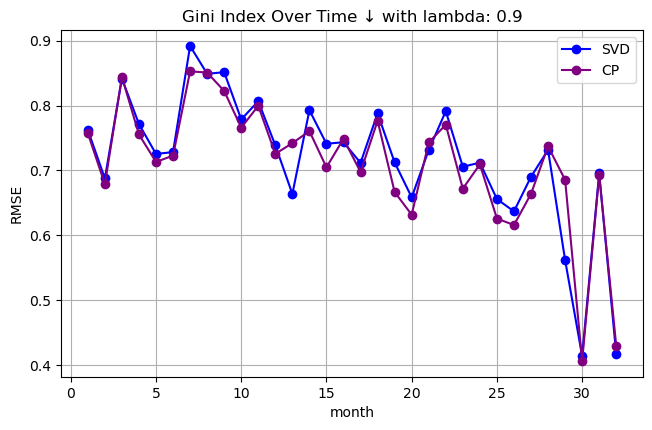

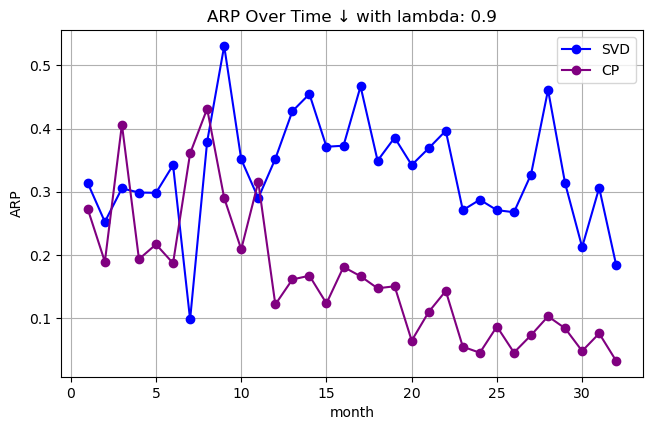

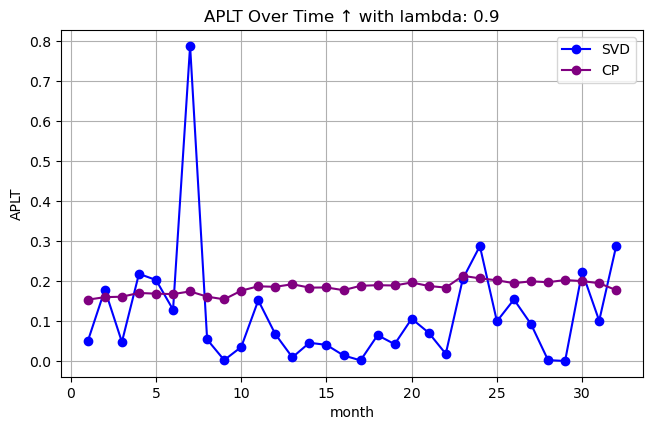

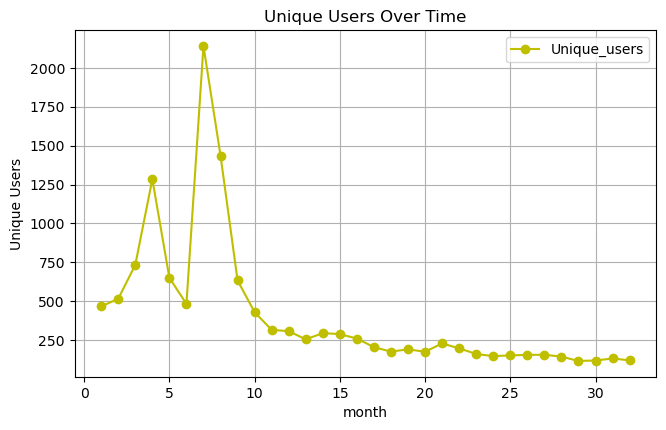

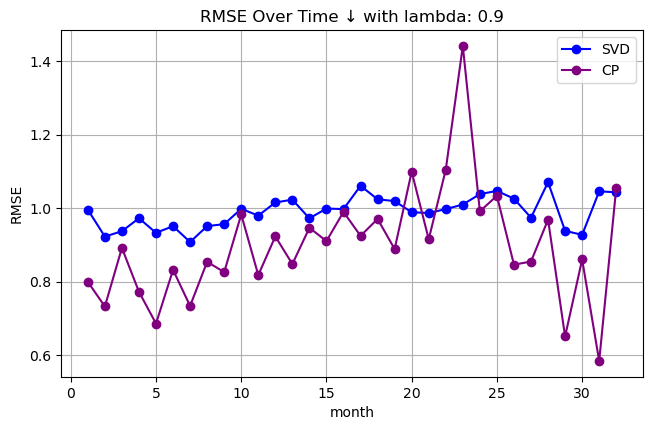

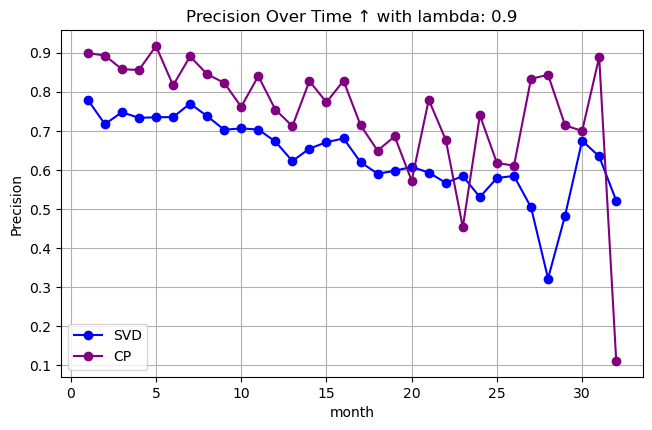

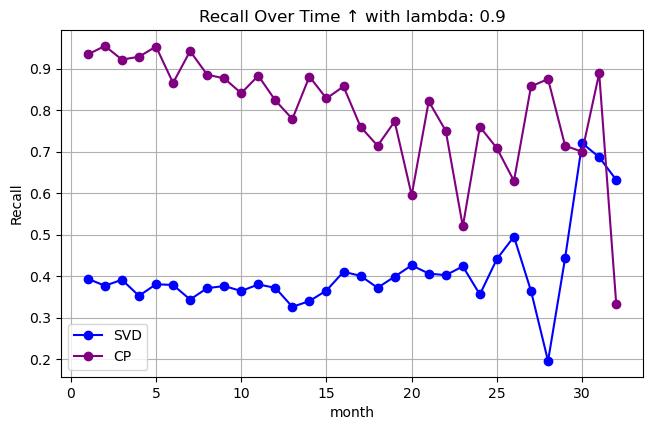

In [41]:
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, gini_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='CP')
plt.title(f'Gini Index Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig(f'gini{alpha}.png')
plt.show()

#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, arp, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='CP')
plt.title(f'ARP Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.savefig(f'arp{alpha}.png')
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, aplt, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['aplt'], marker='o', color='purple', label='CP')
plt.title(f'APLT Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.savefig(f'aplt{alpha}.png')
plt.show()

#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('month')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, rmse_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['rmse'], marker='o', color='purple', label='CP')
plt.title(f'RMSE Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig(f'rmse{alpha}.png')
plt.show()

#Precision 
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, precision_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['precision@10'], marker='o', color='purple', label='CP')
plt.title(f'Precision Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.savefig(f'precision{alpha}.png')
plt.show()

#Recall
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, recall_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['recall@10'], marker='o', color='purple', label='CP')
plt.title(f'Recall Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.savefig(f'recall{alpha}.png')
plt.show()

In [ ]:
"""
#Gini
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, gini_values, marker='o', color='b', label='Gini index')
plt.title('Gini index Over Time ↓')
plt.xlabel('month')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='Gini Index CP')
plt.title('Gini index Over Time ↓')
plt.xlabel('month')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()


#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, arp, marker='o', color='b', label='ARP')
plt.title('ARP Over Time ↓')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='ARP CP')
plt.title('ARP Over Time ↓')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, aplt, marker='o', color='b', label='APLT')
plt.title('APLT Over Time ↑')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['aplt'], marker='o', color='purple', label='APLT CP')
plt.title('APLT Over Time ↑')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.show()

#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('month')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, rmse_values, marker='o', color='b', label='RMSE')
plt.title('RMSE Over Time ↓')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['rmse'], marker='o', color='purple', label='RMSE CP')
plt.title('RMSE Over Time ↓')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

#Precision 
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, precision_values, marker='o', color='b', label='Precision@10')
plt.title('Precision Over Time ↑')
plt.xlabel('month')
plt.ylabel('Precision@K')
plt.grid(True)
plt.legend()
plt.show()

#Precision CP
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['precision@10'], marker='o', color='purple', label='Precision@10 CP')
plt.title('Precision Over Time ↑')
plt.xlabel('month')
plt.ylabel('Precision@K')
plt.grid(True)
plt.legend()
plt.show()

#Recall
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, recall_values, marker='o', color='b', label='Recall@10')
plt.title('Recall Over Time ↑')
plt.xlabel('month')
plt.ylabel('Recall@K')
plt.grid(True)
plt.legend()
plt.show()

#Recall CP
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['recall@10'], marker='o', color='purple', label='Recall@10 CP')
plt.title('Recall Over Time ↑')
plt.xlabel('month')
plt.ylabel('Recall@K')
plt.grid(True)
plt.legend()
plt.show()
"""

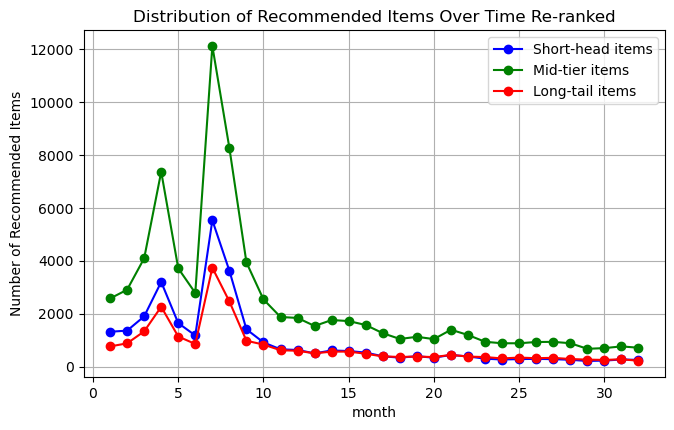

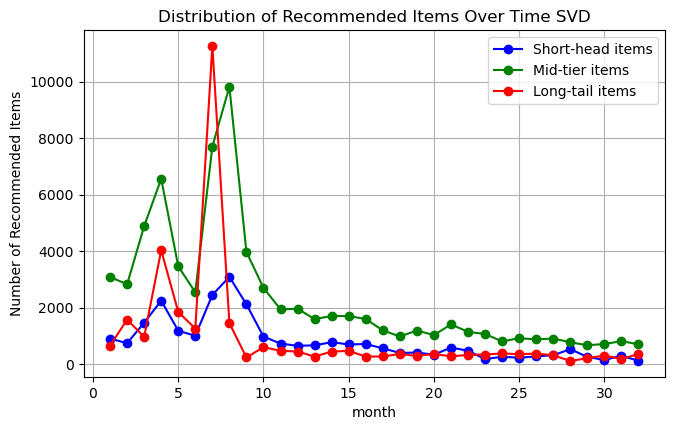

In [42]:
months = group_counts_df['month']
short_head_counts = group_counts_df['short_head_count']
mid_counts = group_counts_df['mid_count']
long_tail_counts = group_counts_df['long_tail_count']


plt.figure(figsize=(7.5, 4.5))

plt.plot(months, short_head_counts, marker='o', color='b', label='Short-head items')
plt.plot(months, mid_counts, marker='o', color='g', label='Mid-tier items')
plt.plot(months, long_tail_counts, marker='o', color='r', label='Long-tail items')

plt.title('Distribution of Recommended Items Over Time Re-ranked')
plt.xlabel('month')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

plt.show()


months2 = group_counts_svd_df['month']
short_head_counts2 = group_counts_svd_df['short_head_count']
mid_counts2 = group_counts_svd_df['mid_count']
long_tail_counts2 = group_counts_svd_df['long_tail_count']

plt.figure(figsize=(7.5, 4.5))

plt.plot(months2, short_head_counts2, marker='o', color='b', label='Short-head items')
plt.plot(months2, mid_counts2, marker='o', color='g', label='Mid-tier items')
plt.plot(months2, long_tail_counts2, marker='o', color='r', label='Long-tail items')

plt.title('Distribution of Recommended Items Over Time SVD')
plt.xlabel('month')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

plt.show()

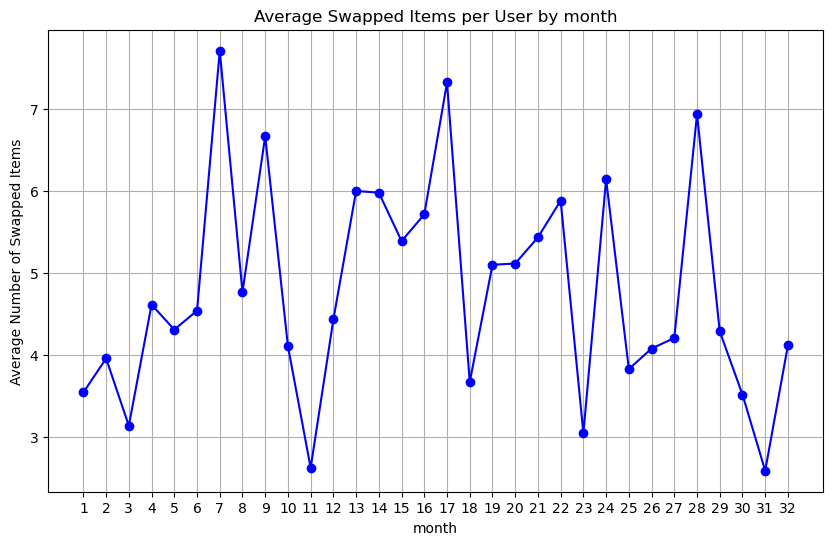

In [43]:
months = sorted(monthly_swapped_counts.keys())
avg_swaps = [monthly_swapped_counts[w] for w in months]

plt.figure(figsize=(10,6))
plt.plot(months, avg_swaps, marker='o', linestyle='-', color='b')
plt.title("Average Swapped Items per User by month")
plt.xlabel("month")
plt.ylabel("Average Number of Swapped Items")
plt.grid(True)
plt.xticks(months)
plt.show()


In [ ]:
# Ensure the timestamp column is a datetime type
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

# Convert timestamps to monthly periods
monthly_periods = ratings['timestamp'].dt.to_period('M')

# Count the unique months
num_months = monthly_periods.nunique()
print("Number of months in the dataset:", num_months)

In [ ]:
precision_values = [result['precision@10'] for result in monthly_results]

cp_mean_precision = np.mean(results_df['precision@10'])
svd_mean_precision =np.mean(precision_values)

print(f"Mean precision for CP: {cp_mean_precision:.4f}")
print(f"Mean precision for SVD: {svd_mean_precision:.4f}")

In [ ]:
recall_values = [result['recall@10'] for result in monthly_results]

cp_mean_recall = np.mean(results_df['recall@10'])
svd_mean_recall =np.mean(recall_values)

print(f"Mean recall for CP: {cp_mean_recall:.4f}")
print(f"Mean recall for SVD: {svd_mean_recall:.4f}")

In [ ]:
rmse_values = [result['rmse'] for result in monthly_results]

cp_mean_rmse = np.mean(results_df['rmse'])
svd_mean_rmse =np.mean(rmse_values)

print(f"Mean rmse for CP: {cp_mean_rmse:.4f}")
print(f"Mean rmse for SVD: {svd_mean_rmse:.4f}")

In [ ]:
# Build a small summary DataFrame

summary = pd.DataFrame({
    'Metric':       ['RMSE ↓',       'Precision@10 ↑',       'Recall@10 ↑'],
    'SVD':          [svd_mean_rmse, svd_mean_precision,  svd_mean_recall],
    'CP': [cp_mean_rmse, cp_mean_precision, cp_mean_recall]
})
#summary = summary.round(3)
from tabulate import tabulate
print(
    tabulate(
        summary, 
        headers="keys", 
        tablefmt="github", 
        floatfmt=".3f", 
        showindex=False
    )
)


In [ ]:
gini_values = [result['gini_index'] for result in monthly_results]
cp_mean_gini = np.mean(results_df['gini_index'])

svd_mean_gini =np.mean(gini_values)

print(f"Mean Gini Index for CP: {cp_mean_gini:.4f}")
print(f"Mean Gini Index for SVD: {svd_mean_gini:.4f}")

In [ ]:
arp_values = [result['arp'] for result in monthly_results]

cp_mean_arp = np.mean(results_df['arp'])
svd_mean_arp =np.mean(arp_values)

print(f"Mean arp for CP: {cp_mean_arp:.4f}")
print(f"Mean arp for SVD: {svd_mean_arp:.4f}")

In [ ]:
aplt_values = [result['aplt'] for result in monthly_results]

cp_mean_aplt = np.mean(results_df['aplt'])
svd_mean_aplt =np.mean(aplt_values)

print(f"Mean aplt for CP: {cp_mean_aplt:.4f}")
print(f"Mean aplt for SVD: {svd_mean_aplt:.4f}")

In [ ]:
# Build a small summary DataFrame

summary = pd.DataFrame({
    'Beyond Metric':       ['Gini-Index ↓',       'ARP ↓',       'APLT ↑'],
    'SVD':          [svd_mean_gini, svd_mean_arp,  svd_mean_aplt],
    'CP': [cp_mean_gini, cp_mean_arp, cp_mean_aplt]
})
#summary = summary.round(3)
from tabulate import tabulate
print(
    tabulate(
        summary, 
        headers="keys", 
        tablefmt="github", 
        floatfmt=".3f", 
        showindex=False
    )
)


In [ ]:
top10_df = (
    recommendations_df
    # 1) Sort by month, then user, then rating descending 
    .sort_values(['month','userId','rating'], ascending=[True,True,False])
    # 2) For each (month, userId) pair, keep only the first 10 rows
    .groupby(['month','userId'], group_keys=False)
    .head(10)
    .reset_index(drop=True)
)
top10_df.head(15)

In [ ]:
total_movies = set(ratings['movieId'].unique())

recommended_movies = set(top10_df['movieId'].unique())
recommended_movies2 = set(reranked_df['movieId'].unique())

coverage = len(recommended_movies) / len(total_movies)
coverage2 = len(recommended_movies2) / len(total_movies)
print(f"Coverage SVD: {coverage:.2%}\t" 
     f"Coverage CP: {coverage2:.2%}") 

In [ ]:
coverages = []

for month in sorted(top10_df['month'].unique()):
    dfm = top10_df[top10_df['month'] == month]
    rec_items = set(dfm['movieId'])
    total_items = ratings['movieId'].nunique()
    cov = len(rec_items) / total_items * 100
    print(f"Month {month} catalog coverage: {cov:.2f}%")
    coverages.append(cov)

# now compute the average
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage monthly catalog coverage: {avg_cov:.2f}%")
else:
    print("No months to average.")


In [ ]:
coverages = []

for month in sorted(reranked_df['month'].unique()):
    dfm = reranked_df[reranked_df['month'] == month]
    rec_items = set(dfm['movieId'])
    total_items = ratings['movieId'].nunique()
    cov = len(rec_items) / total_items * 100
    print(f"Month {month} catalog coverage: {cov:.2f}%")
    coverages.append(cov)

# now compute the average
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage monthly catalog coverage: {avg_cov:.2f}%")
else:
    print("No months to average.")


In [ ]:
# 1) Build a DataFrame of (userId, movieId) from your train_test_sets
test_rows = [
    (user, movie)
    for _, testset, _, _ in train_test_sets
    for user, movie, _ in testset
]
test_df = pd.DataFrame(test_rows, columns=['userId', 'movieId']).drop_duplicates()

# 2) Merge with your top-10 recommendation DataFrame
merged = (
    top10_df
    .merge(test_df,
           on=['userId','movieId'],
           how='left',
           indicator=True)
)

# 3) Calculate Test‐coverage@10
hits = (merged['_merge'] == 'both').sum()
total_slots = len(top10_df)  # should be n_users * 10
coverage_at_10 = hits / total_slots

print(f"Test‐coverage@10 SVD: {coverage_at_10:.2%}")



In [ ]:
# 1) Build a DataFrame of (userId, movieId) from your train_test_sets
test_rows = [
    (user, movie)
    for _, testset, _, _ in train_test_sets
    for user, movie, _ in testset
]
test_df = pd.DataFrame(test_rows, columns=['userId', 'movieId']).drop_duplicates()

# 2) Merge with your top-10 recommendation DataFrame
merged = (
    reranked_df
    .merge(test_df,
           on=['userId','movieId'],
           how='left',
           indicator=True)
)

# 3) Calculate Test‐coverage@10
hits = (merged['_merge'] == 'both').sum()
total_slots = len(top10_df)  # should be n_users * 10
coverage_at_10 = hits / total_slots

print(f"Test‐coverage@10 CP: {coverage_at_10:.2%}")


In [ ]:
# 1) Build a list of all months in your recommendations
months = sorted(top10_df['month'].unique())

# 2) Map each month to its testset
#    (zip relies on the fact that train_test_sets is in the same order)
month_to_test = {
    month: testset
    for month, (_, testset, *_rest) in zip(months, train_test_sets)
}

coverages = []

for month in months:
    # 3) Extract that month’s top-10 recs
    dfm = top10_df[top10_df['month'] == month][['userId','movieId']]

    # 4) Build a DataFrame of unique (userId, movieId) for that month’s test
    test_rows = [
        (u, m)
        for u, m, _ in month_to_test[month]
    ]
    test_df_month = (
        pd.DataFrame(test_rows, columns=['userId','movieId'])
          .drop_duplicates()
    )

    # 5) Merge & flag which slots hit
    merged = dfm.merge(
        test_df_month,
        on=['userId','movieId'],
        how='left',
        indicator=True
    )
    hits        = (merged['_merge'] == 'both').sum()
    total_slots = len(dfm)           # should be n_users_for_month × 10
    cov_pct     = hits / total_slots * 100

    print(f"Month {month} test‐coverage@10: {cov_pct:.2f}%")
    coverages.append(cov_pct)

# 6) Average across months
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage test‐coverage@10 over {len(coverages)} months for SVD: {avg_cov:.2f}%")
else:
    print("No months to process.")


In [ ]:
# 1) Build a list of all months in your recommendations
months = sorted(reranked_df['month'].unique())

# 2) Map each month to its testset
#    (zip relies on the fact that train_test_sets is in the same order)
month_to_test = {
    month: testset
    for month, (_, testset, *_rest) in zip(months, train_test_sets)
}

coverages = []

for month in months:
    # 3) Extract that month’s top-10 recs
    dfm = reranked_df[reranked_df['month'] == month][['userId','movieId']]

    # 4) Build a DataFrame of unique (userId, movieId) for that month’s test
    test_rows = [
        (u, m)
        for u, m, _ in month_to_test[month]
    ]
    test_df_month = (
        pd.DataFrame(test_rows, columns=['userId','movieId'])
          .drop_duplicates()
    )

    # 5) Merge & flag which slots hit
    merged = dfm.merge(
        test_df_month,
        on=['userId','movieId'],
        how='left',
        indicator=True
    )
    hits        = (merged['_merge'] == 'both').sum()
    total_slots = len(dfm)           # should be n_users_for_month × 10
    cov_pct     = hits / total_slots * 100

    print(f"Month {month} test‐coverage@10: {cov_pct:.2f}%")
    coverages.append(cov_pct)

# 6) Average across months
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage test‐coverage@10 over {len(coverages)} months for CP: {avg_cov:.2f}%")
else:
    print("No months to process.")


In [ ]:
# === OVERALL USER OVERLAP ===

# Collect all raw user‐IDs seen in any train split
train_users = set()
for trainset, _, *_ in train_test_sets:
    train_users |= { trainset.to_raw_uid(uid) for uid in trainset.all_users() }

# Collect all user‐IDs seen in any test split
test_users = set()
for _, testset, *_ in train_test_sets:
    test_users |= { u for u, _, _ in testset }

overlap = train_users & test_users

print(f"Overall train users: {len(train_users)}")
print(f"Overall test  users: {len(test_users)}")
print(f"Overlap users     : {len(overlap)} "
      f"({len(overlap)/len(test_users)*100:.2f}% of test users)")

# === PER-MONTH USER OVERLAP ===

# If you want to see it month by month:
months = sorted(top10_df['month'].unique())
for month, (trainset, testset, *_ ) in zip(months, train_test_sets):
    train_u = { trainset.to_raw_uid(uid) for uid in trainset.all_users() }
    test_u  = { u for u, _, _ in testset }
    ov      = train_u & test_u
    pct     = len(ov) / len(test_u) * 100 if test_u else 0.0
    print(f"Month {month}: {len(ov)} overlapping users "
          f"({pct:.2f}% of that month’s test users)")


In [ ]:
# 1) Gather per-month counts
months       = sorted(top10_df['month'].unique())
train_counts = []
test_counts  = []
overlap_counts = []

for month, (trainset, testset, *_) in zip(months, train_test_sets):
    # users seen in training (Surprise trainset)
    train_users = {trainset.to_raw_uid(uid) for uid in trainset.all_users()}
    # users in that month's test
    test_users  = {u for u, _, _ in testset}
    overlap     = train_users & test_users

    train_counts.append(len(train_users))
    test_counts.append(len(test_users))
    overlap_counts.append(len(overlap))

# 2) Plot all three series on one chart
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, overlap_counts, marker='o', label='Overlap users')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of users')
plt.title('Number of users who appear in both the Train and Test set')
plt.legend()
plt.grid(True)
plt.show()